# Drawing Stellar Populations from IMFs

## Context 

The IMF tells us about the relative frequencies of stars of various masses in linear mass space. We normalize the initial mass function (IMF) as a probability density function (pdf).  For functions normalized as a pdf we use the symbol $p(m)$. The standard normalization condition for a probability is $1 = \int_{m_l}^{m_u} p(m)dm$, where $m_l$ and $m_u$ are the lower and upper mass limit, respectively. In particular, we take up here three functional forms of the IMF: Salpeter (1955), Kroupa (2001), and Chabrier (2003). In all cases, $A$ represents a global normalization constant:

$$p_{\text{Salpeter}}(m) = Am^{-2.35}$$

 ---
 
$$p_{\text{Kroupa}}(m) = \begin{cases} 
      Ak_0m^{-0.3} & 0.01M_\odot< m<0.08M_\odot\ \\
      Ak_1m^{-1.3} & 0.08M_\odot< m<0.5M_\odot\ \\
      Ak_2m^{-2.3} & 0.5M_\odot< m<1M_\odot\ \\
      Ak_3m^{-2.3} & 1M_\odot< m<(150M_\odot)
   \end{cases}$$

with $k_0 = 1$, $k_1 = k_0m_1^{-0.3+1.3}$, $k_2 = k_1m_2^{-1.3+2.3}$ and $k_3 = k_2m_3^{-2.3+2.3}(=k_2)$ where $m_1 = 0.08M_\odot$, $m_2 = 0.5M_\odot$, and $m_3 = 1M_\odot$. The reason that the last two branches are not combined is because the exponents have different uncertainities in the original paper, but for the purposes of subsequent calculations, we combine them into one branch applying over $0.5 M_{\odot} < m < (150M_\odot)$.
  
   
 ---
 
$$p_{\text{Chabrier}}(m) = \begin{cases} 
      Ak_1\frac{1}{m}e^{\frac{1}{2}\left(\frac{\log_{10}m - \log_{10}0.079}{0.69}\right)^2} & 0.01M_\odot< m<1M_\odot\ \\
      Ak_2m^{-2.3} & 1M_\odot< m<(150M_\odot)
   \end{cases}$$
  with $k_1 = 0.158$ and $k_2 = 0.0443$.

---
(All of the above taken from https://doi.org/10.1093/mnras/sts479)

## Our Problem

Given some stellar suface density $\Sigma_{*}$ and some area in the sky $A$, we want to populate $A$ with stars having having masses drawn according to some IMF.

with $k_0 = 1$, $k_1 = k_0m_1^{-0.3+1.3}$, $k_2 = k_1m_2^{-1.3+2.3}$ and $k_3 = k_2m_3^{-2.3+2.3}(=k_2)$ where $m_1 = 0.08M_\odot$, $m_2 = 0.5M_\odot$, and $m_3 = 1M_\odot$. The reason that the last two branches are not combined is because the exponents have different uncertainities in the original paper, but for the purposes of subsequent calculations, we combine them into one branch applying over $0.5 M_{\odot} < m < (150M_\odot)$.

### Step 1: Normalize

Let's take the Salpeter case as an example. The mass range over which the Salpeter IMF is applicable is not clear, but we adopt the commonly used $0.1 M_{\odot} < m < 100 M_{\odot}$ (https://doi.org/10.1017/pasa.2018.29). We use $\texttt{scipy.integrate.quad}$ to obtain numerically that $\int_{0.1 M_{\odot}}^{100 M_{\odot}} m^{-2.35} = 16.58$. From the condition that $1 = \int_{m_l}^{m_u} p(m)dm$, then, we obtain that $A = \frac{1}{16.58}$.

In [1]:
import numpy as np
from scipy.integrate import quad 

def unnormalized_salpeter(m):
    return m ** -2.35

m_min_salpeter = 0.1
m_max_salpeter = 100

unnormalized_salpeter_integral = quad(unnormalized_salpeter, m_min_salpeter, m_max_salpeter)
A_salpeter = 1 / unnormalized_salpeter_integral[0]

def unnormalized_kroupa(m):
    m_min = 0.01
    m_1 = 0.08
    m_2 = 0.5
    m_max = 150
    k_0 = 1
    k_1 = k_0 * m_1 ** (-0.3 + 1.3)
    k_2 = k_1 * m_2 ** (-1.3 + 2.3)
    if (m_min <= m) and (m < m_1):
        return k_0 * m ** -0.3
    elif (m_1 <= m) and (m < m_2):
        return k_1 * m ** -1.3
    elif (m_2 <= m) and (m <= m_max):
        return k_2 * m ** (-2.3)

m_min_kroupa = 0.01
m_max_kroupa = 150

unnormalized_kroupa_integral = quad(unnormalized_kroupa, m_min_kroupa, m_max_kroupa)
A_kroupa = 1 / unnormalized_kroupa_integral[0]

def unnormalized_chabrier(m):
    m_min = 0.01
    m_1 = 1
    m_max = 150
    k_1 = 0.158
    k_2 = 0.0443
    if (m_min <= m) and (m <= m_1):
        return k_1 * (1 /m) * np.exp((1 / 2) * ((np.log10(m) - np.log10(0.079)) / 0.69) ** 2)
    elif (m_1 < m) and (m <= m_max):
        return k_2 * m ** (-2.3)
    
m_min_chabrier = 0.01
m_max_chabrier = 150

unnormalized_chabrier_integral = quad(unnormalized_chabrier, m_min_chabrier, m_max_chabrier)
A_chabrier = 1 / unnormalized_chabrier_integral[0]

def normalized_salpeter(m):
    return A_salpeter * unnormalized_salpeter(m)

def normalized_kroupa(m):
    return A_kroupa * unnormalized_kroupa(m)

def normalized_chabrier(m):
    return A_chabrier * unnormalized_chabrier(m)

### Step 2(?): Determine Expectation Values of the Mass
As usual, the expectation value is the first moment of the distribution, $\langle m \rangle = \int_{m_l}^{m_u} mp(m)dm$.

In [2]:
def first_moment_salpter(m):
    return m * normalized_salpeter(m)

def first_moment_kroupa(m):
    return m * normalized_kroupa(m)

def first_moment_chabrier(m):
    return m * normalized_chabrier(m)

m_exp_salpeter = quad(first_moment_salpter, m_min_salpeter, m_max_salpeter)[0]
m_exp_kroupa = quad(first_moment_kroupa, m_min_kroupa, m_max_kroupa)[0]
m_exp_chabrier = quad(first_moment_chabrier, m_min_chabrier, m_max_chabrier)[0]

### Step 3(?): Determine how many stars we need to populate $A$
An area $A$ with stellar suface density $\Sigma_{*}$ contains $M_{\text{tot}} = \Sigma_{*}A$. This is, on average, the total mass of $N = \frac{M_{\text{tot}}}{\langle m \rangle}$ stars.

NOTE: The sample mean mass of the $N$ masses we draw might not be close to the population $\langle m \rangle$. This can lead to either an undershoot or overshoot of the mass.

In [3]:
def N(sigma, A, imf):
    M_tot = sigma * A
    if imf == "salpeter":
        return int(M_tot / m_exp_salpter)
    elif imf == "kroupa":
        return int(M_tot / m_exp_kroupa)
    elif imf == "chabrier":
        return int(M_tot / m_exp_chabrier)

### Step 4: Inverse Transform Sampling

The task of drawing samples given a pdf is referred to as the *generation of random variates from  a distribution*. The standard method for the generation of random variates is *inverse transform sampling*. 

The idea is to obtain the cumulative distribution function (cdf) $P(m)$ by integration of the pdf. The cdf takes as input some $m$ and gives the probability $P(M < m) = p$. The inverse cdf, $P^{-1}$, then, takes as input $p$ and returns $m$. But by the definition of a probability, $p \sim \text{Unif}(0,1)$, so if we have a method for generating $u$'s, we can sample from any distribution by plugging the $u$'s into its inverse cdf (see further mathematical details here: https://www.columbia.edu/~ks20/4404-Sigman/4404-Notes-ITM.pdf).

The below is a numerical implementation of inverse transform sampling from https://github.com/sibirrer/hierArc/blob/905f027909ffee63323a792aab9c670e553aacd5/hierarc/Util/distribution_util.py#L36.

In [4]:
from scipy.interpolate import interp1d

class PDFSampling(object):
    """Class for approximations with a given pdf sample."""

    def __init__(self, bin_edges, pdf_array):
        """

        :param bin_edges: bin edges of PDF values
        :param pdf_array: pdf array of given bins (len(bin_edges)-1)
        """
        assert len(bin_edges) == len(pdf_array) + 1
        self._cdf_array, self._cdf_func, self._cdf_inv_func = approx_cdf_1d(
            bin_edges, pdf_array
        )

    def draw(self, n=1):
        """

        :return:
        """
        p = np.random.uniform(0, 1, n)
        return self._cdf_inv_func(p)

    @property
    def draw_one(self):
        """

        :return:
        """
        return self.draw(n=1)


def approx_cdf_1d(bin_edges, pdf_array):
    """

    :param bin_edges: bin edges of PDF values
    :param pdf_array: pdf array of given bins (len(bin_edges)-1)
    :return: cdf, interp1d function of cdf, inverse interpolation function
    """
    assert len(bin_edges) == len(pdf_array) + 1
    norm_pdf = pdf_array / np.sum(pdf_array)
    cdf_array = np.zeros_like(bin_edges)
    cdf_array[0] = 0
    for i in range(0, len(norm_pdf)):
        cdf_array[i + 1] = cdf_array[i] + norm_pdf[i]
    cdf_func = interp1d(bin_edges, cdf_array)
    cdf_inv_func = interp1d(cdf_array, bin_edges)
    return cdf_array, cdf_func, cdf_inv_func

### <span style="color:red">NOTE</span>
 At this stage, we have two options. We can either draw $N = \frac{M_{\text{tot}}}{\langle m \rangle}$ samples directly in the above by doing ${\_}\texttt{.draw(N)}$, or we can draw *single* samples until we reach (in practice, slightly exceed) our desired total mass. The first method has a fundamental problem, especially pronounced for relatively small $N$: the sample mean is (normally) *distributed* around the poplulation $\langle m \rangle$, but it doesn't *equal* it. As a concrete example, $\langle m \rangle_{\text{Salpeter}} = 0.35 M_{\odot}$, so if we wanted to populate an area having total projected mass $35 M_{\odot}$, we'd need $N=100$ stars. One such draw yielded $100$ stars with average mass of just $0.25 M_{\odot}$. This is an illustration of the fact that we will almost certainly under- or over-shoot the total desired mass by the first method. 
 
So although the second method is computationally slower, we proceed with it. Steps 2 and 3 are thus rendered superflous, but we keep them above for completeness.

### Step 5: Draw single samples until the accumulated mass reaches the desired mass

Note that we can't apply the $\texttt{normalized}\_\texttt{kroupa}$ and $\texttt{normalized}\_\texttt{chabrier}$ pdfs to $m$ the way we do $\texttt{normalized}\_\texttt{salpeter}$, since the former two are piecewise-defined.

In [5]:
def draw(sigma, A, imf):
    M_tot = sigma * A
    m_accumulated = 0
    masses = []
    if imf == "salpeter":
        m = np.linspace(m_min_salpeter, m_max_salpeter, 10000)
        salpeter_bin_edges = np.linspace(m_min_salpeter, m_max_salpeter, 10001)
        salpeter_pdf = normalized_salpeter(m)
        sampler = PDFSampling(salpeter_bin_edges, salpeter_pdf)
    elif imf == "kroupa":
        m = np.linspace(m_min_kroupa, m_max_kroupa, 10000)
        kroupa_bin_edges = np.linspace(m_min_kroupa, m_max_kroupa, 10001)
        kroupa_pdf = np.array([normalized_kroupa(mass) for mass in m]) # need list first since piecewise def. 
        sampler = PDFSampling(kroupa_bin_edges, kroupa_pdf)
    elif imf == "chabrier":
        m = np.linspace(m_min_chabrier, m_max_chabrier, 10000)
        chabrier_bin_edges = np.linspace(m_min_chabrier, m_max_chabrier, 10001)
        chabrier_pdf = np.array([normalized_chabrier(mass) for mass in m]) # need list first since piecewise def. 
        sampler = PDFSampling(chabrier_bin_edges, chabrier_pdf)
    while m_accumulated < M_tot:
        mass = sampler.draw()[0]
        masses.append(mass)
        m_accumulated += mass
    return np.array(masses)

# An Example 

Let us study a lens at redshift $z = 0.5$, a source at $z = 1.5$. We can compute the *lensing critical surface density* $\Sigma_{\text{cr}}$, and given a value for the convergence $\kappa$, we can obtain $\Sigma_{*}$ by $\kappa\Sigma_{\text{cr}}$. 

Let us consider an area of $1$ milliarcsecond (mas)$^{2}$ on the sky. The idea behind this choice of area is that we cover effectively all the area where multiple images can appear within a strong lensing environment.

In [6]:
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

lens_cosmo = LensCosmo(z_lens=0.01, z_source=1.5)
sigma_crit = lens_cosmo.sigma_crit
proj_mass = lens_cosmo.kappa2proj_mass(kappa = 0.5) # M_sol / Mpc ^ 2

mpc_in_arcsec = lens_cosmo.phys2arcsec_lens(phys = 1) # arcsec value corresponding to 1 Mpc at lens redshift
proj_mass_arcsec = proj_mass / (mpc_in_arcsec) ** 2 # M_sol / arcsec ^ 2

In [7]:
salpeter_mass_sample = draw(proj_mass_arcsec, 0.001, "salpeter")
kroupa_mass_sample = draw(proj_mass_arcsec, 0.001, "kroupa")
chabrier_mass_sample = draw(proj_mass_arcsec, 0.001, "chabrier")

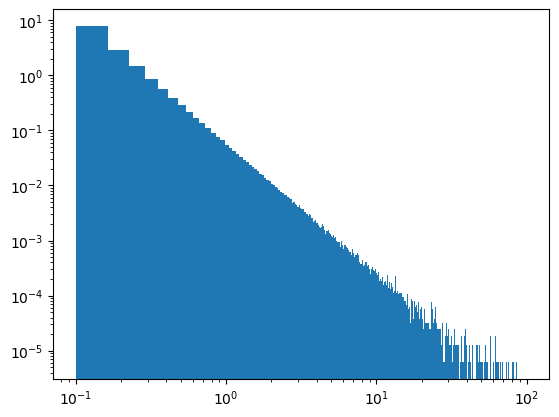

In [9]:
import matplotlib.pyplot as plt

plt.hist(salpeter_mass_sample, bins = int(np.sqrt(len(salpeter_mass_sample))), density = True)
plt.xscale("log")
plt.yscale("log")

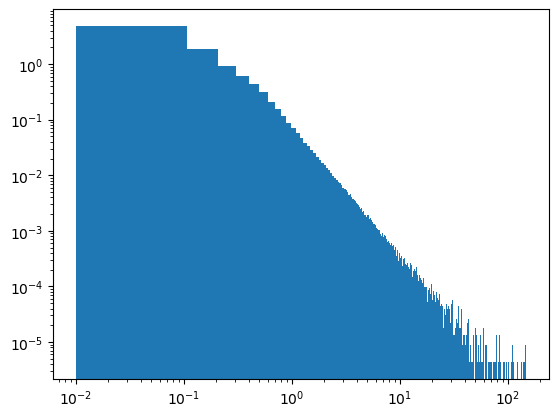

In [10]:
plt.hist(kroupa_mass_sample, bins = int(np.sqrt(len(kroupa_mass_sample))), density = True)
plt.xscale("log")
plt.yscale("log")

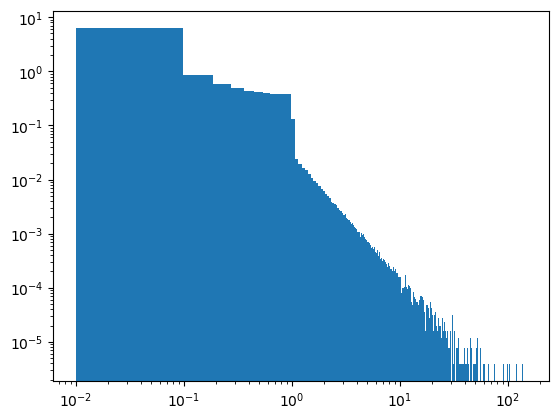

In [11]:
plt.hist(chabrier_mass_sample, bins = int(np.sqrt(len(chabrier_mass_sample))), density = True)
plt.xscale("log")
plt.yscale("log")